## Домашнее задание "Методология ведения DS-проектов"

Возьмите задачу с винами (https://www.kaggle.com/rajyellow46/wine-quality) и решите ее, оформив в виде CrispDM-подхода. Решение - jupyter notebook на github или colab.

# 1. Понимание бизнеса

## 1.1 Цель 

Предсказать вкусовую оценку качества вина по шкале от 1 до 10

## 1.2 Описание 

Вино являтся популярным алкогольным напитком, востребованным по всему миру. Вкус и качество вина зависят от множества факторов: даже из одного и того же сорта винограда, собранного с одной террритории, могут получится вина, отличающиеся друг от друга (например, из-за неоднородного состава почвы или неодинакового солнечного освещения). 

Компания-производитель "Wihno Verde" соединила данные о физико-химических параметрах различных вин с оценками качества. В этой задаче необходимо изучить взаимосвязь состава вина и его оценки. 

## 1.3 Ограничения
Из-за особенностей логистики и проблем с конфиденциальностью доступны только физико-химические (исходные) и сенсорные (целевая) переменные. Например, нет данных о сортах винограда, марке вина, продажной цене вина.

## 1.4 Дополнительная информация
- [Описание датасета на Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)
- P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

# 2. Data understanding

## 2.1 Import libraries

In [58]:
# базовые операции с матрицами и датасетами
import numpy as np
import pandas as pd 

# библиотеки для визуализации  
import matplotlib.pyplot as plt
import seaborn as sns 

# Предобработка данных
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Модели классификации
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Оценка результатов
from sklearn.metrics import classification_report, accuracy_score
# Перебалансировка классов
from imblearn.over_sampling import SMOTE

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

# Импорт локальных вспомогательных функций
import os
from Scripts import plotting, download_data

# для сохранения весов модели
import pickle

## 2.2 Вспомогательные функции


In [36]:
def train_and_predict(model, x_train, x_test, y_train, y_test):
    '''
    Обучение модели классификации и вывод результатов
    '''
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'{model.__class__.__name__} result')
    print(classification_report(y_pred, y_test))
    print('----------------------------------')
    
def make_dummies(df, col):
    '''
    Преобразование One-hot encoding для одной колонки в датасете'''
    dummies = pd.get_dummies(df[col])
    dummies = dummies.add_prefix("{}_".format(col))
    df.drop(col, axis=1, inplace=True)
    df = df.join(dummies)
    return df

## 2.3 Загрузка данных


In [37]:
# Загрузка данных с kaggle

download_data.download_data()

In [38]:
module_path = os.path.abspath(os.path.join('..'))
df = pd.read_csv(module_path+'\\Data\\winequalityN.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [39]:
df.shape

(6497, 13)

Набор данных включает в себя 6497 строк и 13 признаков, один из которых - качество - является целевой переменной

## 2.4 Статистика и визуализации

**Описание переменных**

 - type (тип вина)
 - fixed acidity (фиксированная кислотность)
 - volatile acidity (летучая кислотность)
 - citric acid (лимонная кислота)
 - residual sugar (остаточный сахар)
 - chlorides (хлориды)
 - free sulfur dioxide (свободный диоксид серы)
 - total sulfur dioxide (суммарный диоксид серы)
 - density (плотность)
 - pH
 - sulphates (сульфаты)
 - alcohol (спирт)
 - quality (оценка качества от 0 до 10)
 
**Детализация признаков**
 
- Фиксированная кислотность обусловлена наличием нелетучих кислот (например, яблочной) в вине. Данный тип кислот участвует в сбалансированности вкуса вина.
- Летучая кислотность – это та часть кислот в вине, которую можно уловить носом (в отличие от тех кислот, которые ощутимы на вкус). Основные виновники – уксусная кислота (пахнет уксусом) и её эфир – этилацетат (пахнет лаком для ногтей).  Обычно высокий уровень кислостности считается нежелательным.
- Остаточный сахар - харктеристика, показывающая количество углеводов, которое осталось после завершения процесса брожения. По этому параметру вина подразделяются на сухие, полусухие, полусладкие и сладкие.
- Диоксид серы - результат жизнедеятельности дрожжей, сбраживающих сахар в вине в алкоголь. Сера – это естественный антиоксидант и антисептик. Это элемент, подавляющий рост бактерий, замедляющий старение вина, его преждевременное окисление и ненужное брожение. Допустимая доза сульфитов в алкоголе (по американским стандартам) — 400 мг/л.
- Характеристика pH может выступать характеристикой цвета вина: вина с высоким pH темнее и имеют фиолетовый оттенок цвета, с низким pH светлее и имеют ярко-розовый или ярко-красный отенок цвета.
- Этиловый спирт — основной спирт, содержащийся в продуктах виноделия. Его концентрация в столовых винах 9—14% об., в десертных 12—17% об., в крепких 17—20% об.


### 2.4.1  Ключевая информация о переменных

In [40]:
#  для числовых переменных
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


- В стобце quality видим значения от 3 до 9. То есть у нас представлены не все возможные оценки качества вина, нет очень плохих (0,1,2) и нет отличных (10) вин
- Параметр спирт изменяется в пределах, допустимых для столовых и десертных вин
- Максимальное значение параметра Суммарный диоксид серы 440, это превышает норматив. Однако значения медианы и даже 75 процентиля намного меньше и в нормативные рамки попадают.
- В целом у параметров Фиксированная кислотность, Летучая кислотность, Остаточный сахар, Сульфаты так же наблюдается заметный разрыв между медианным и максимальным значением, хотя разница между минимальным и медианным невелика. Скорее всего мы увидим несколько распределений с длинным хвостом справа.


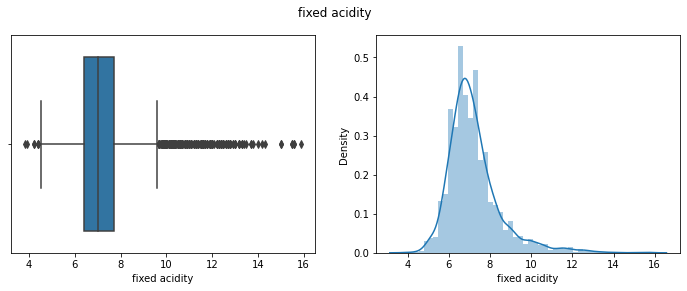

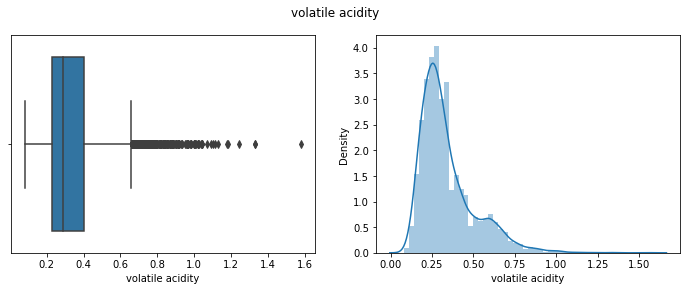

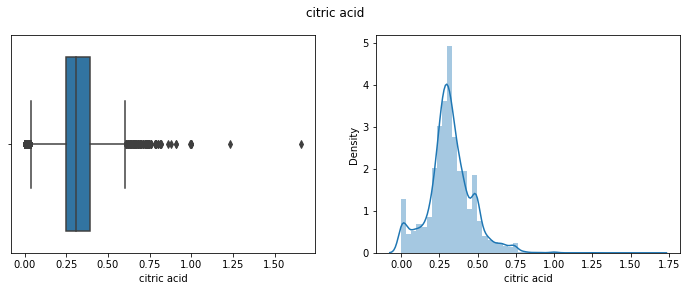

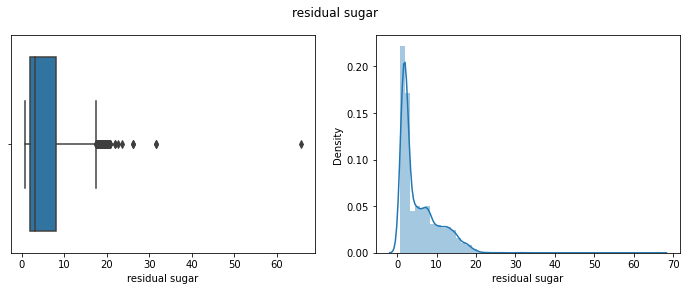

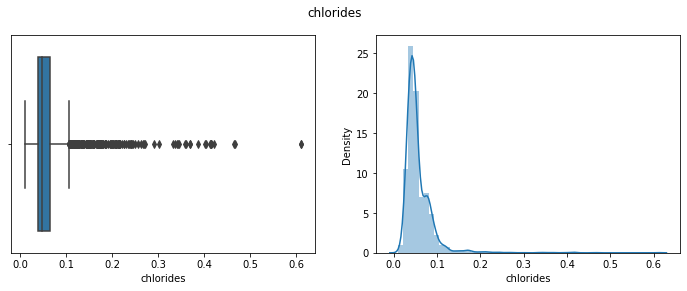

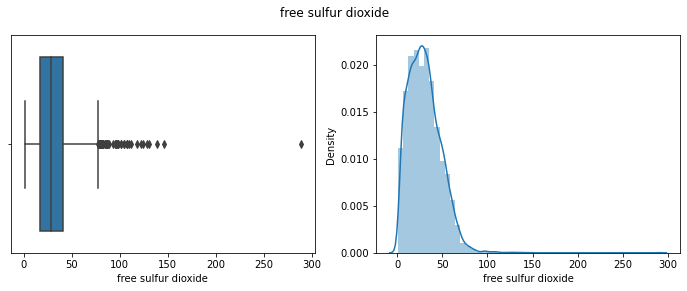

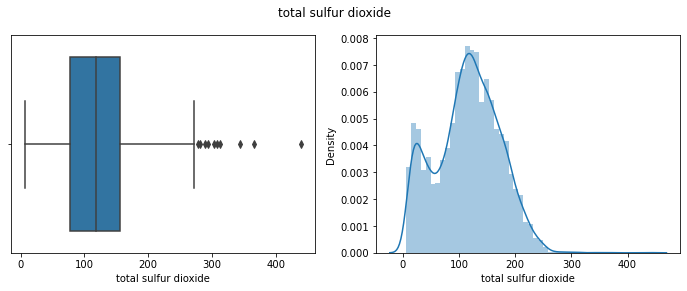

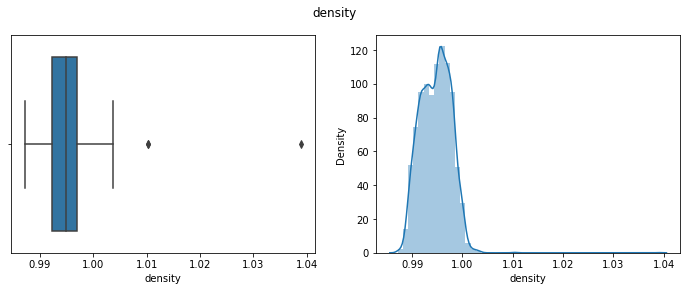

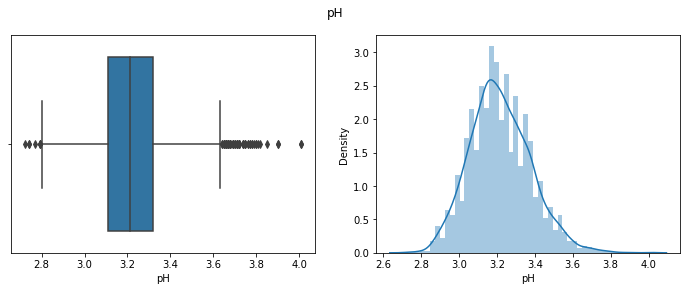

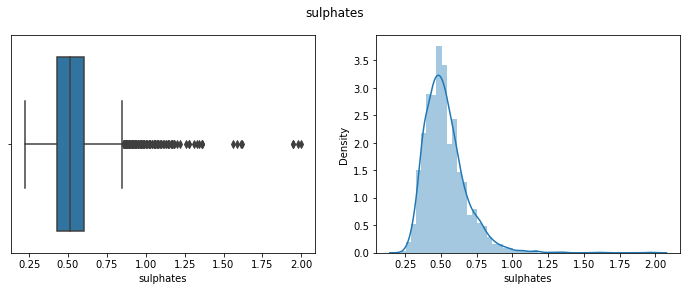

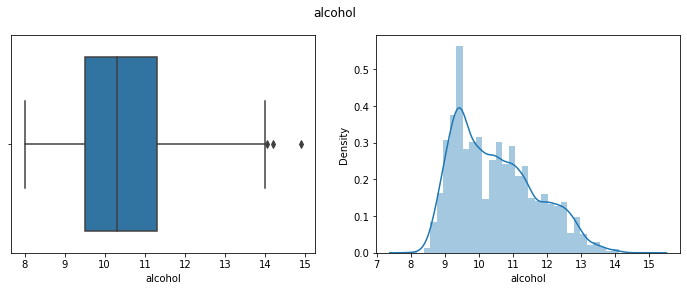

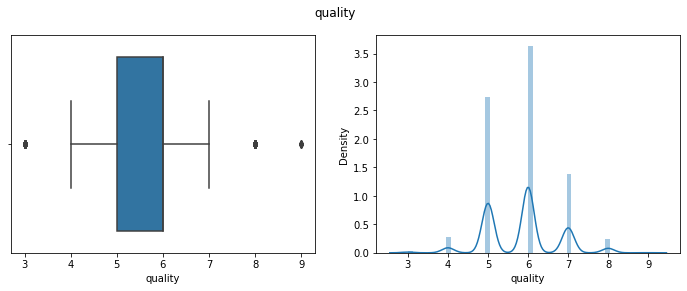

In [6]:
# визуализация распределений
plotting.plot_hists_and_boxes(df, df.columns)


Действительно, есть несколько распределения с хвостами справа, и многие значения на боксплотах определены как выбросы. 
В выбросы попали так же оценки качества вина 3, 8 и 9. Распределение по классам значений целевой переменной можно назвать сильно несбалансированным

In [22]:
# для единственной категориальной переменной
df.type.describe()

count      6497
unique        2
top       white
freq       4898
Name: type, dtype: object

Типов вина представлено 2. Есть достаточно заметный дисбаланс классов: белого вина больше, чем красного. 

<AxesSubplot:xlabel='type', ylabel='count'>

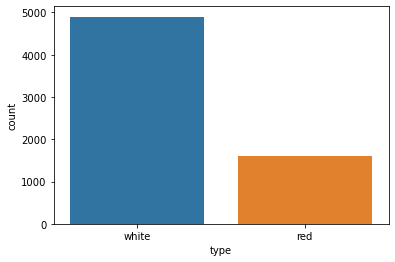

In [23]:
sns.countplot(x='type', data=df)

### 2.4.2 Тепловая карта корреляции

<AxesSubplot:>

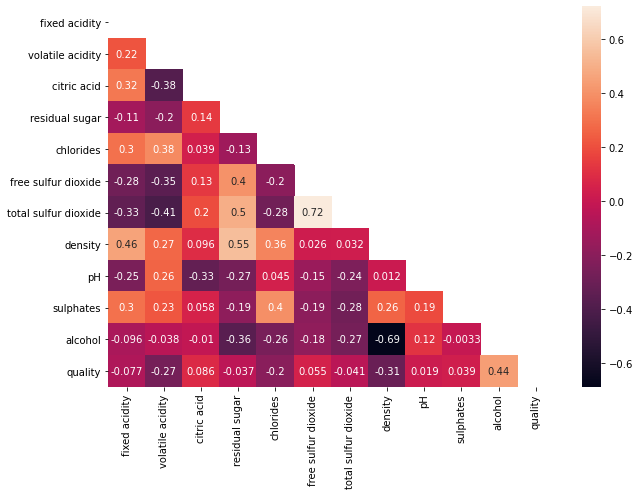

In [24]:
plt.figure(figsize=(10, 7))
matrix = np.triu(df.drop('type', axis=1).corr())
sns.heatmap(df.drop('type', axis=1).corr(), annot=True, mask=matrix)

- С целевой переменной имеют более выраженную корреляционную связь параметры Спирт, Плотность (умеренная положительная корреляция) и летучая кислотность (отрицательная корреляция). Наименьшую связь показывают параметры pH и остаточный сахар, значения корреляции с целевой переменной близки к 0.
- У параметров Спирт и Плотность - сильная отрицательная корреляция. 
- Суммарный диоксид серы и Свободный диоксид серы - сильная положительная корреляция.
- Умеренная положительная корреляция плотности с переменными Остаточный сахар, Суммарный диоксид серы и Свободный диоксид серы.

### 2.4.3 Взаимосвязь между признаками и целевой переменной

Посмотрим на зависимости между целевой и наиболее скоррелированными с ней переменными

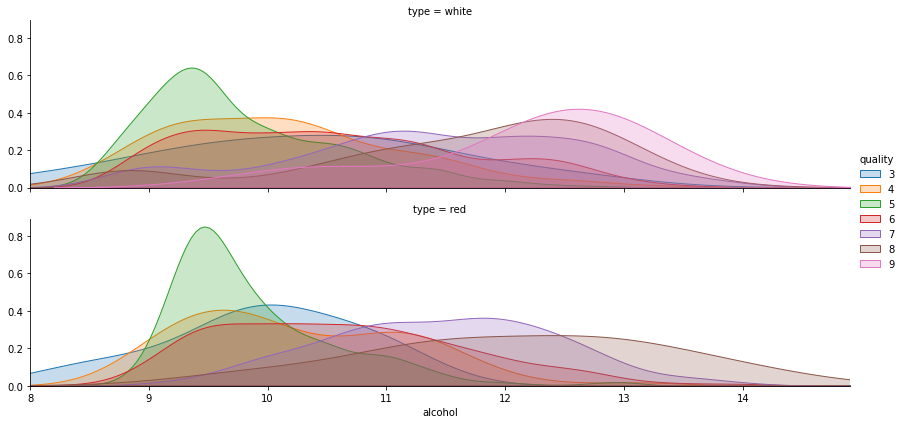

In [7]:
plotting.plot_distribution(df, var='alcohol', target='quality', row='type')

Для для обоих типов вин с высокими оценками больше характерно высокое содержание алкоголя в составе, для вин с низкими оценками - меньшее содержание алкоголя.

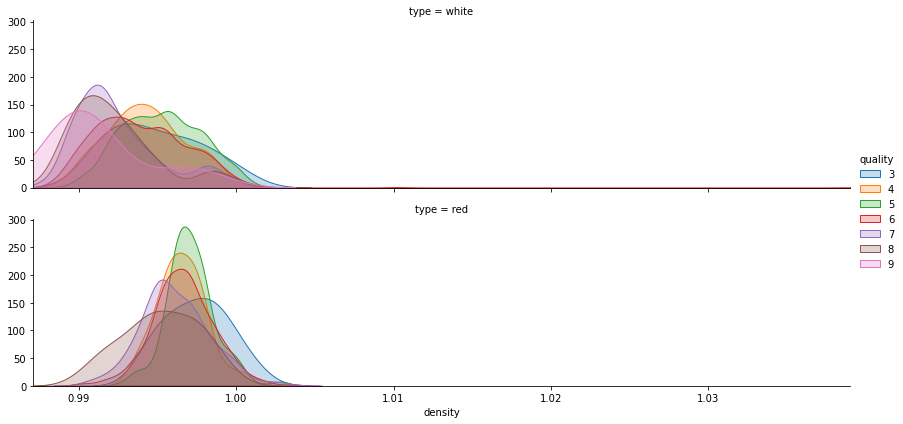

In [8]:
plotting.plot_distribution(df, var='density', target='quality', row='type')

Видно, что есть какие-то экстремально высокие (для этого измерения) значения показателя плотность для белых вин с невысокой оценкой (4).
Для хороших (оценки 7,8,9) белых вин характерна меньшая плотность, чем для хороших красных вин

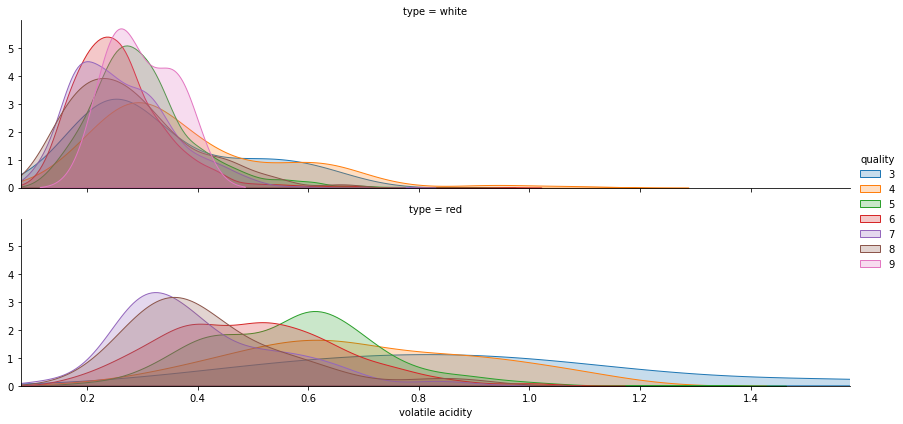

In [9]:
plotting.plot_distribution(df, var='volatile acidity', target='quality', row='type')

Для белых вин характерно меньшее содержание летучих кислот, чем для красных

### 2.4.4 Распределение занчений целевой переменной

<AxesSubplot:xlabel='quality', ylabel='count'>

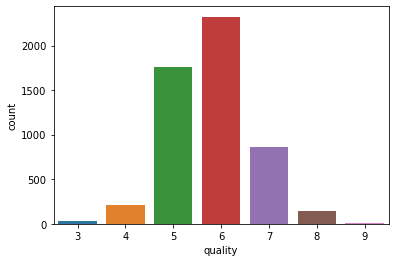

In [70]:
sns.countplot(x='quality', data=df)

Наблюдается сильный дисбаланс классов. Большую часть датасета представляют вина среднего качества. Плохих (3, 4) и хороших  (8, 9) оценок немного, а очень плохих (1, 2) и очень хороших (10) нет совсем.

# 3. Data preparation

## 3.1 Работа с пропущенными значениями

In [41]:
cols_with_missings = []
for col in df.columns:
    missings = np.sum(df[col].isnull())
    if missings > 0: 
        print('{} - {}'.format(col, missings))
        cols_with_missings.append(col)

fixed acidity - 10
volatile acidity - 8
citric acid - 3
residual sugar - 2
chlorides - 2
pH - 9
sulphates - 4


В каждой из колонок не более 10 пропущенных значений, это немного. Заполним пропущенные значения средними величинами каждого из признаков.

In [42]:
for col in cols_with_missings:
    mean = df[col].mean()
    df[col].fillna(mean, inplace=True)

## 3.2 Трансформация ассиметричных признаков

На этапе знакомства с данными мы увидели, что распределения некоторых признаков обладают длинными хвостами справа. Известно, что алгоритмы ML лучше работают, когда распределение больше походит на нормальное распределение. Поэтому к колонкам датасета с  высокими положительными коэффициентами ассиметрии применю операцию логарифмирования.

In [43]:
skewValue = df.skew(axis=0)
high_skew_cols = list(skewValue[skewValue>1].index)

In [44]:
for col in high_skew_cols:
    df[col] = np.log(df[col])

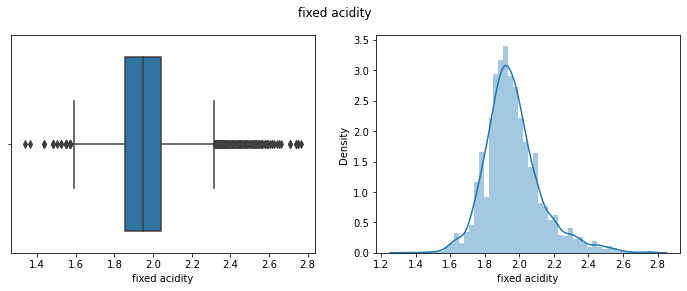

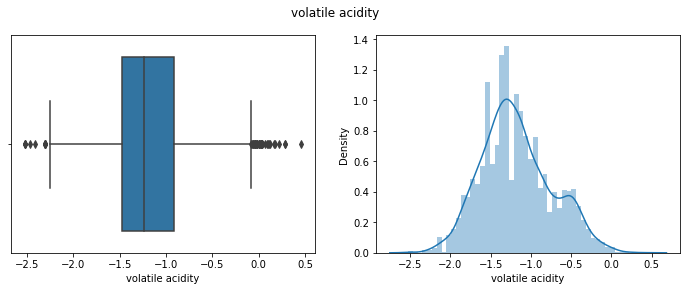

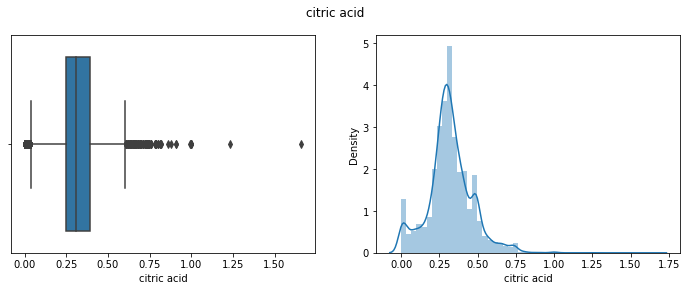

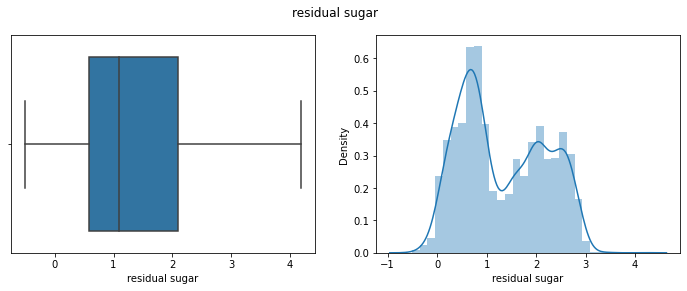

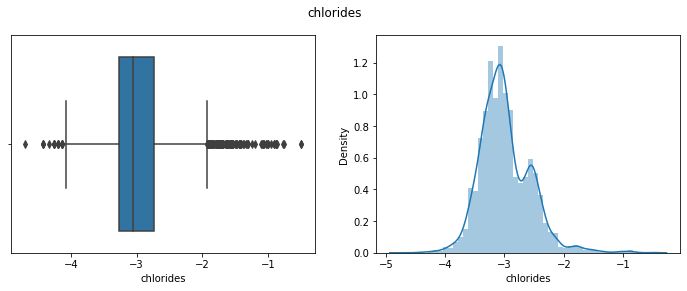

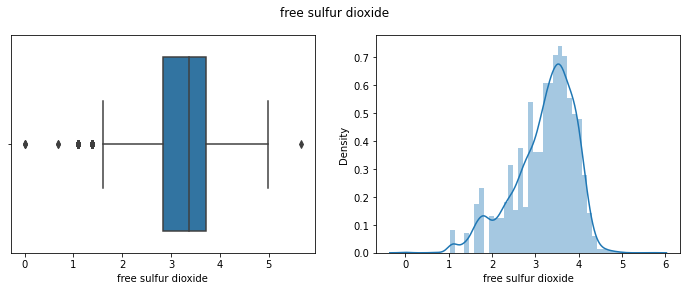

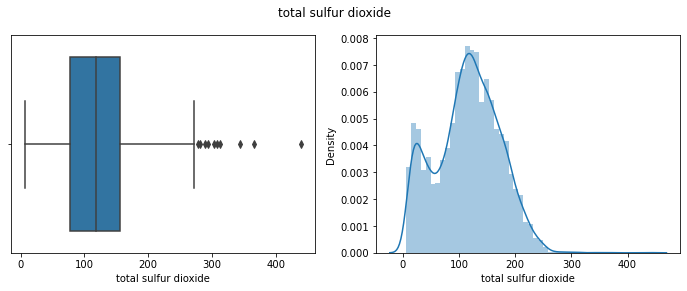

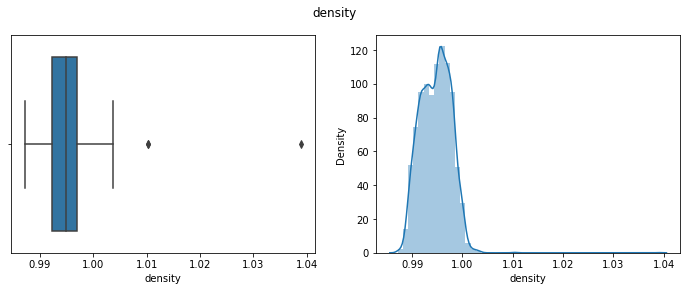

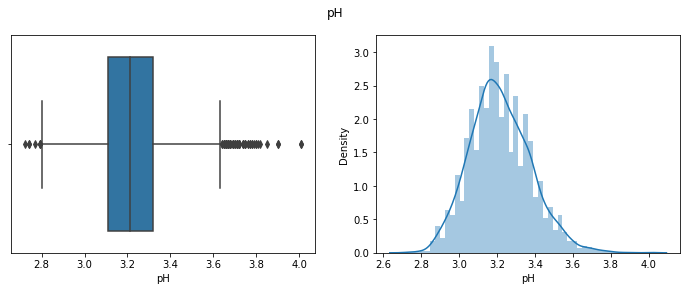

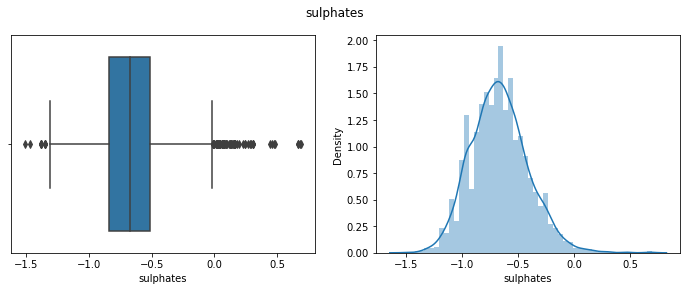

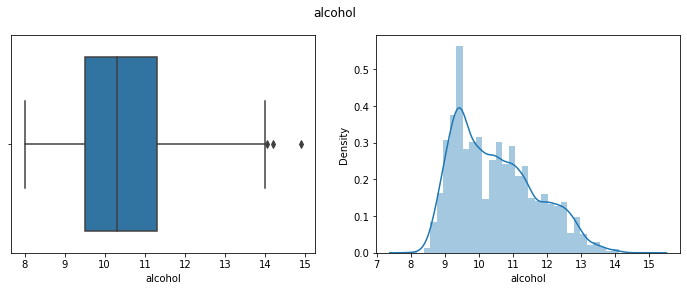

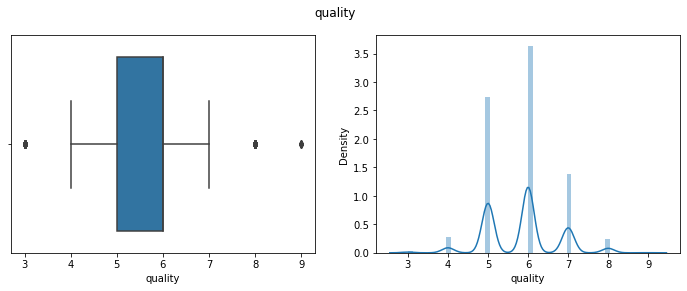

In [15]:
plotting.plot_hists_and_boxes(df, df.columns)

## 3.3 Преобразование категориальных признаков в числовые

В этом датасете только признак "type" является категориальным. Применим к нему one-hot encoding

In [45]:
df = make_dummies(df, 'type')

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,1.945910,-1.309333,0.36,3.030134,-3.101093,3.806662,170.0,1.0010,3.00,-0.798508,8.8,6,0,1
1,1.840550,-1.203973,0.34,0.470004,-3.015935,2.639057,132.0,0.9940,3.30,-0.713350,9.5,6,0,1
2,2.091864,-1.272966,0.40,1.931521,-2.995732,3.401197,97.0,0.9951,3.26,-0.820981,10.1,6,0,1
3,1.974081,-1.469676,0.32,2.140066,-2.847312,3.850148,186.0,0.9956,3.19,-0.916291,9.9,6,0,1
4,1.974081,-1.469676,0.32,2.140066,-2.847312,3.850148,186.0,0.9956,3.19,-0.916291,9.9,6,0,1


## 3.4 Добавление новых признаков

По количеству остаточного сахара мы можем выделить несколько групп вин
- Сухие вина содержат до 4 г/л
- Полусухие - 4—18 г/л
- Полусладкие — 18—45 г/л
- Сладкие — не менее 45 г/л

Эта классификация интуитивно более понятна человеку без специфических знаний в предметной области. Попробуем добавить новый признак Sweetness. 

In [43]:
def get_sweetness(row):
    result = ''
    if row < 4:
        result = 'dry'
    elif 4 <= row < 18:
        result = 'medium dry'
    elif 18 <= row < 45:
        result = 'medium sweet'
    elif row >= 45:
        result = 'sweet'
    return result

In [55]:
df['sweetness'] = df['residual sugar'].apply(get_sweetness)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white,sweetness
0,1.945910,-1.309333,0.36,3.030134,-3.101093,3.806662,170.0,1.0010,3.00,-0.798508,8.8,6,0,1,dry
1,1.840550,-1.203973,0.34,0.470004,-3.015935,2.639057,132.0,0.9940,3.30,-0.713350,9.5,6,0,1,dry
2,2.091864,-1.272966,0.40,1.931521,-2.995732,3.401197,97.0,0.9951,3.26,-0.820981,10.1,6,0,1,dry
3,1.974081,-1.469676,0.32,2.140066,-2.847312,3.850148,186.0,0.9956,3.19,-0.916291,9.9,6,0,1,dry
4,1.974081,-1.469676,0.32,2.140066,-2.847312,3.850148,186.0,0.9956,3.19,-0.916291,9.9,6,0,1,dry


In [56]:
# все строки заполнены новым признаком, пропусков нет
df[df['sweetness']=='']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white,sweetness


In [57]:
df = df.drop('residual sugar', axis = 1)

In [58]:
df = make_dummies(df, 'sweetness')

df.head()

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white,sweetness_dry,sweetness_medium dry
0,1.945910,-1.309333,0.36,-3.101093,3.806662,170.0,1.0010,3.00,-0.798508,8.8,6,0,1,1,0
1,1.840550,-1.203973,0.34,-3.015935,2.639057,132.0,0.9940,3.30,-0.713350,9.5,6,0,1,1,0
2,2.091864,-1.272966,0.40,-2.995732,3.401197,97.0,0.9951,3.26,-0.820981,10.1,6,0,1,1,0
3,1.974081,-1.469676,0.32,-2.847312,3.850148,186.0,0.9956,3.19,-0.916291,9.9,6,0,1,1,0
4,1.974081,-1.469676,0.32,-2.847312,3.850148,186.0,0.9956,3.19,-0.916291,9.9,6,0,1,1,0


## 3.5 Удаление дубликатов строк

In [46]:
df = df.drop_duplicates()

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5329 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5329 non-null   float64
 1   volatile acidity      5329 non-null   float64
 2   citric acid           5329 non-null   float64
 3   residual sugar        5329 non-null   float64
 4   chlorides             5329 non-null   float64
 5   free sulfur dioxide   5329 non-null   float64
 6   total sulfur dioxide  5329 non-null   float64
 7   density               5329 non-null   float64
 8   pH                    5329 non-null   float64
 9   sulphates             5329 non-null   float64
 10  alcohol               5329 non-null   float64
 11  quality               5329 non-null   int64  
 12  type_red              5329 non-null   uint8  
 13  type_white            5329 non-null   uint8  
dtypes: float64(11), int64(1), uint8(2)
memory usage: 551.6 KB


Датасет уменьшен приблизительно на ~1000 строк. Скоращение выборки для обучения это не хорошо, однако дубликаты не внесли бы положительный вклад в обучение моделей. 

## 3.6 Формирование выборки для обучения и валидации моделей

In [30]:
# Сохраним промежуточный результат обработки датасета
df.to_csv('Data/Processed/wine_processed.csv')

In [48]:
X = df.drop('quality', axis=1)
Y = df['quality']

In [49]:
scaler = StandardScaler()

In [50]:
X_scaled = scaler.fit_transform(X)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.25, random_state=146, stratify=Y)

# 4. Моделирование

## 4.1 Baseline

Применим обычную логистическую регрессию

In [73]:
lr = LogisticRegression()

train_and_predict(lr, x_train, x_test, y_train, y_test)


LogisticRegression result
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.08      0.44      0.13         9
           5       0.59      0.59      0.59       441
           6       0.70      0.51      0.59       798
           7       0.19      0.49      0.28        83
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.53      1331
   macro avg       0.22      0.29      0.23      1331
weighted avg       0.63      0.53      0.57      1331

----------------------------------


## 4.2 Выбор модели среди других классификаторов

In [52]:
classifiers = {
    'lr_l1':LogisticRegression(penalty='l1', C=0.1, solver='saga'),
    'lr_l2':LogisticRegression(penalty='l2', C=0.1, solver='saga'),
    'tree':DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(), 
    'knc': KNeighborsClassifier(n_neighbors=7),
    'svc': SVC()
}

In [74]:
for label, model in classifiers.items():
    train_and_predict(model, x_train, x_test, y_train, y_test)


LogisticRegression result
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.04      1.00      0.07         2
           5       0.59      0.58      0.58       446
           6       0.70      0.50      0.58       807
           7       0.17      0.49      0.26        76
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.53      1331
   macro avg       0.21      0.37      0.21      1331
weighted avg       0.63      0.53      0.56      1331

----------------------------------
LogisticRegression result
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.06      0.60      0.11         5
           5       0.59      0.58      0.58       444
           6       0.70      0.50      0.59       805
           7       0.17      0.47      0.25  

Наилучший результат показал алгоритм Random Forest Classifier.

## 4.3 Оценка важности фич

С помощью Random Forest Classifier как раз можем оценить, насколько важны те или иные признаки

In [75]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier()

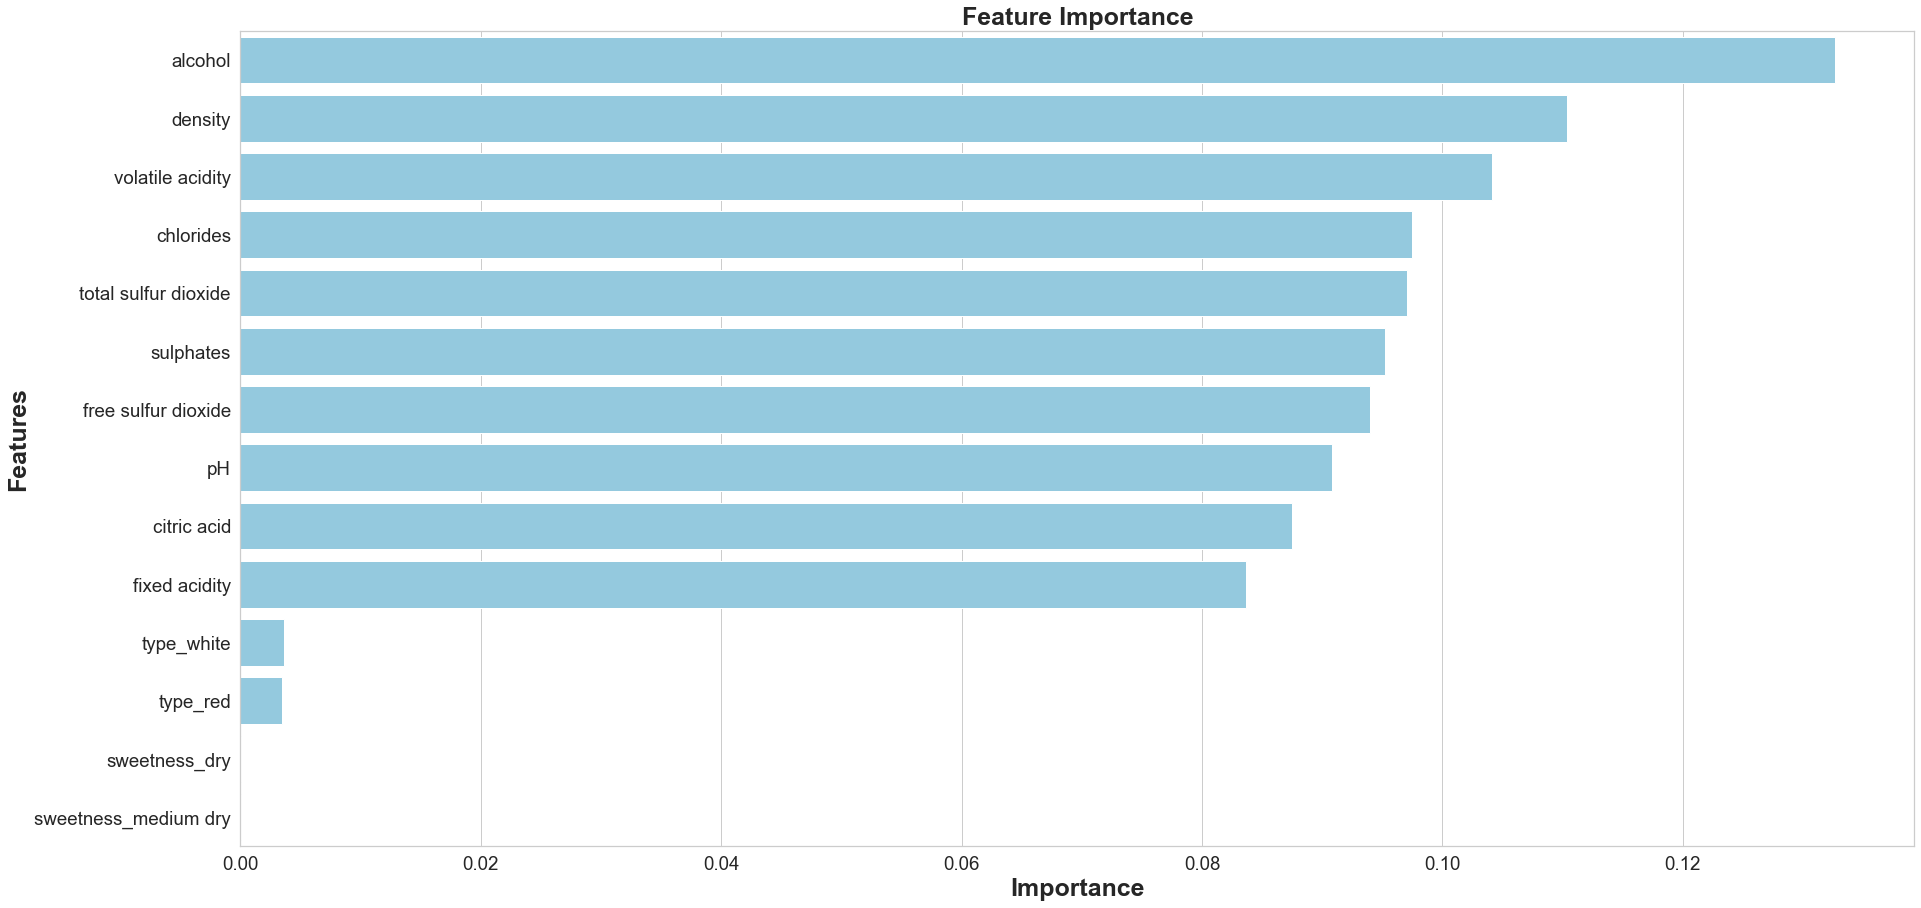

None

In [76]:
plotting.plot_tree_feat_importances(X, rfc)

Наиболее значимыми оказались признаки, у которых наблюдалась более тесная корреляционная связь с целевой переменной.

Новые признаки - категории по степени сладости - моделью приняты за несущественные. 
Процесс моделирования по методологии CrispDM - итеративный. Мы можем вернуться на этап data preparation, вернуть исходный столбец residual sugar, отмасштабировать его как и прочие и проверить, окажет ли это изменение положительное влияение на результат.  

## 4.4 Возврат к data preparation, проверка гипотезы 


In [78]:
res_sugar = pd.read_csv(module_path+'\\Data\\winequalityN.csv')['residual sugar']

In [83]:
df_upd = pd.merge(df, res_sugar, left_index=True, right_index=True)
df_upd = df_upd.drop(['sweetness_dry', 'sweetness_medium dry'], axis = 1)
df_upd.head()

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white,residual sugar
0,1.945910,-1.309333,0.36,-3.101093,3.806662,170.0,1.0010,3.00,-0.798508,8.8,6,0,1,20.7
1,1.840550,-1.203973,0.34,-3.015935,2.639057,132.0,0.9940,3.30,-0.713350,9.5,6,0,1,1.6
2,2.091864,-1.272966,0.40,-2.995732,3.401197,97.0,0.9951,3.26,-0.820981,10.1,6,0,1,6.9
3,1.974081,-1.469676,0.32,-2.847312,3.850148,186.0,0.9956,3.19,-0.916291,9.9,6,0,1,8.5
6,1.824549,-1.139434,0.16,-3.101093,3.401197,136.0,0.9949,3.18,-0.755023,9.6,6,0,1,7.0


In [84]:
df_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5323 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5323 non-null   float64
 1   volatile acidity      5323 non-null   float64
 2   citric acid           5323 non-null   float64
 3   chlorides             5323 non-null   float64
 4   free sulfur dioxide   5323 non-null   float64
 5   total sulfur dioxide  5323 non-null   float64
 6   density               5323 non-null   float64
 7   pH                    5323 non-null   float64
 8   sulphates             5323 non-null   float64
 9   alcohol               5323 non-null   float64
 10  quality               5323 non-null   int64  
 11  type_red              5323 non-null   uint8  
 12  type_white            5323 non-null   uint8  
 13  residual sugar        5322 non-null   float64
dtypes: float64(11), int64(1), uint8(2)
memory usage: 551.0 KB


In [89]:
# Есть один пропуск в добавленном столбце, заполним его
mean = df_upd['residual sugar'].mean()
df_upd['residual sugar'].fillna(mean, inplace=True)

In [90]:
X = df_upd.drop('quality', axis=1)
Y = df_upd['quality']

X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.25, random_state=146, stratify=Y)

In [91]:
for label, model in classifiers.items():
    train_and_predict(model, x_train, x_test, y_train, y_test)


LogisticRegression result
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.06      0.75      0.11         4
           5       0.59      0.59      0.59       445
           6       0.71      0.51      0.59       805
           7       0.17      0.48      0.25        77
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.53      1331
   macro avg       0.22      0.33      0.22      1331
weighted avg       0.64      0.53      0.57      1331

----------------------------------
LogisticRegression result
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.10      0.71      0.17         7
           5       0.60      0.59      0.59       442
           6       0.70      0.51      0.59       798
           7       0.19      0.49      0.28  

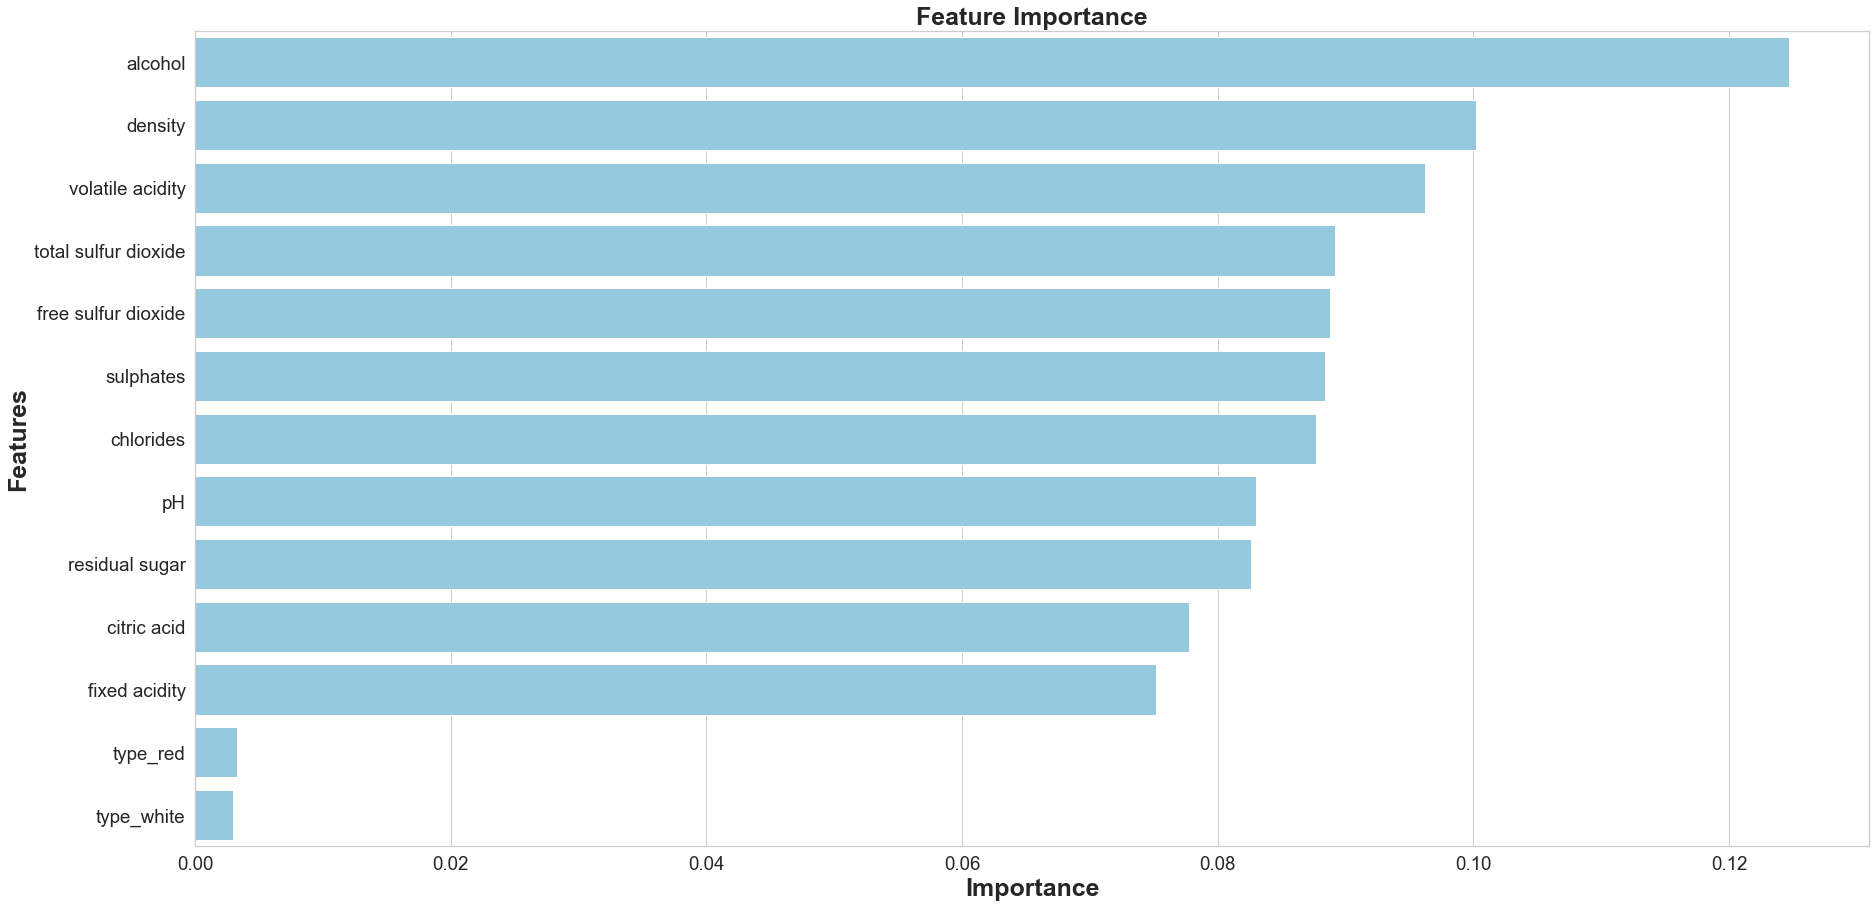

None

In [93]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
plot_tree_feat_importances(X, rfc)

После возвращения признака residual sugar accuracy классификации с помощью случайного леса выросла с 0,57 до 0,58. По оценке важности фич видим, что остаточный сахар только на 9м из 13ти мест, однако его вклад уже не нулевой. Следовательно, возвращение к этому признаку в его исходном виде было полезным.  

## 4.5 Возвращение к data preparation, oversampling

Есть еще одна гипотеза, которая заставляет вернуться к этапу подготовки данных. Она заключается в предположении, что если дисбаланс классов целевой переменной будет снижен, то результат классификации может быть улучшен. 

Дисбаланс классов слишком силен, чтобы приводить все классы к одинаковому количеству элементов в них. С помощью алгоритма SMOTE я добавлю некоторое количество элементов в классы, которые представлены хуже всего так, что в целом плохих и хороших оценок по-прежнему будет меньше средних.

In [53]:
strategy = {3:200, 4:500, 8:500, 9:200}

In [54]:
oversample = SMOTE(sampling_strategy=strategy, k_neighbors=4)
X_new, Y_new = oversample.fit_resample(X_scaled, Y)

In [55]:
x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.25, random_state=146)

In [56]:
for label, model in classifiers.items():
    train_and_predict(model, x_train, x_test, y_train, y_test)

LogisticRegression result
              precision    recall  f1-score   support

           3       0.02      1.00      0.03         1
           4       0.20      0.41      0.27        63
           5       0.61      0.54      0.57       502
           6       0.66      0.45      0.53       831
           7       0.15      0.38      0.21        81
           8       0.14      0.39      0.20        44
           9       0.90      0.71      0.80        63

    accuracy                           0.48      1585
   macro avg       0.38      0.56      0.37      1585
weighted avg       0.60      0.48      0.52      1585

----------------------------------
LogisticRegression result
              precision    recall  f1-score   support

           3       0.09      1.00      0.16         5
           4       0.22      0.43      0.29        67
           5       0.61      0.54      0.57       499
           6       0.65      0.45      0.53       822
           7       0.16      0.38      0.23  

Наилучший результат снова показывает Random Forest Classifier. Accuracy возросла с 0,58 до 0,63

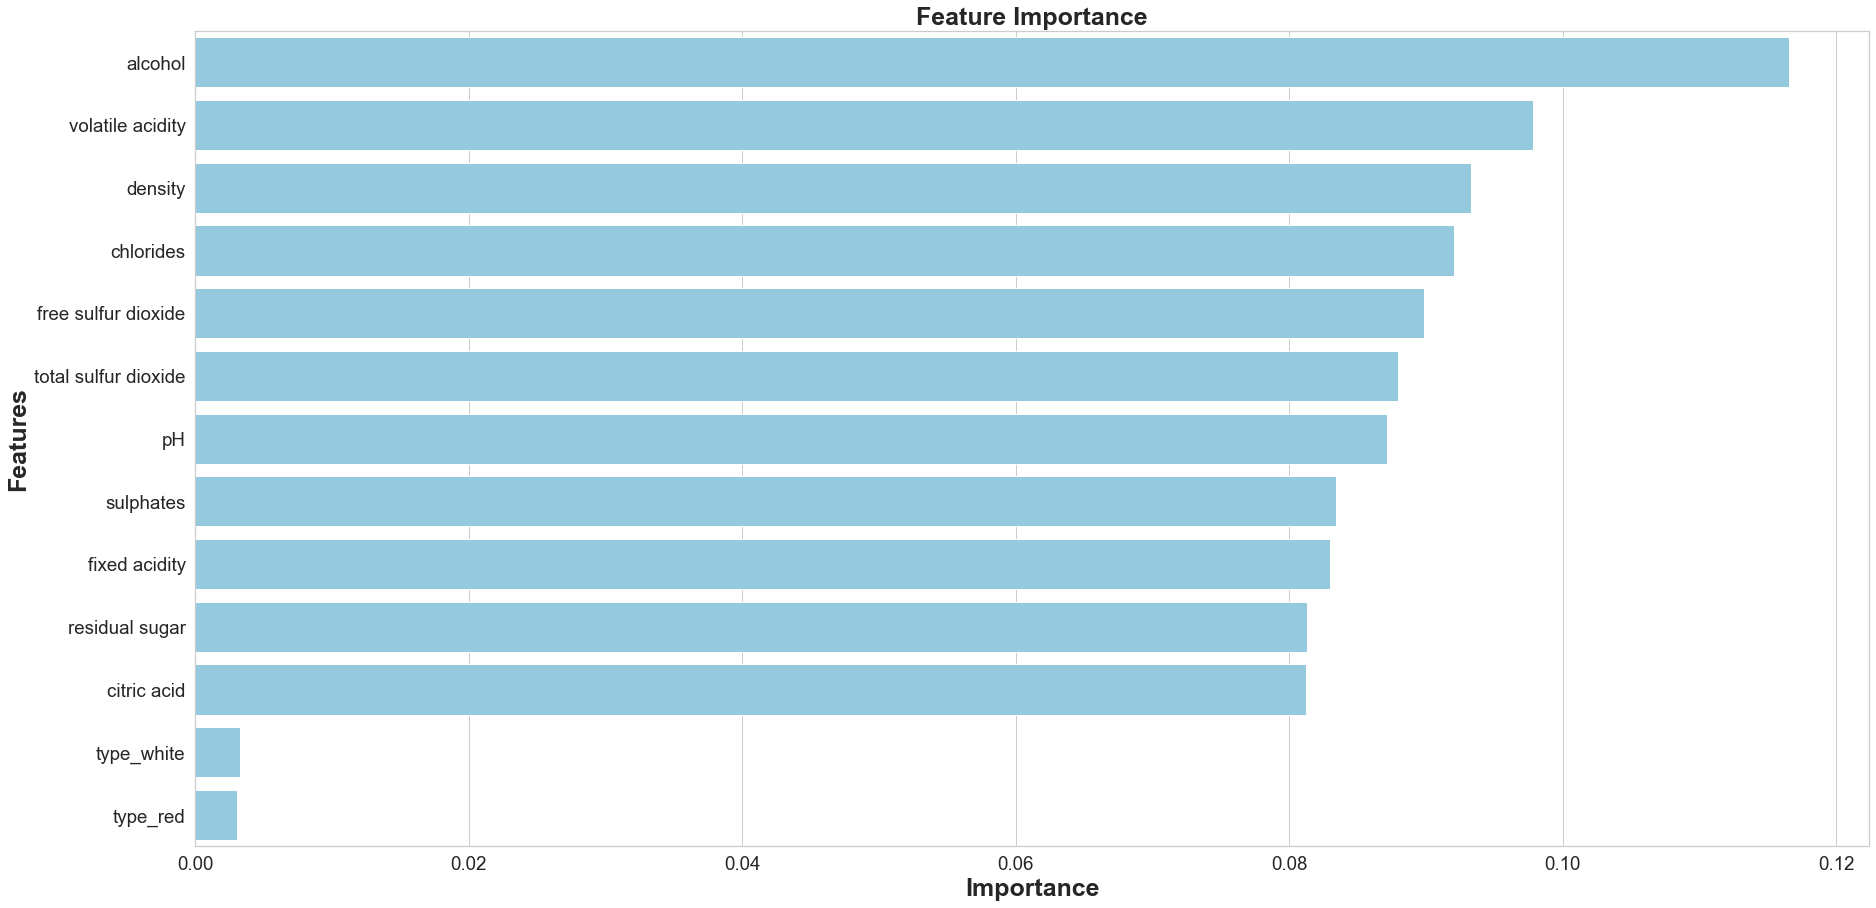

None

In [57]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
plotting.plot_tree_feat_importances(X, rfc)

Важность признаков оценена моделью так же, как и на предыдущем этапе 

In [59]:
# сохраним веса этой модели

filename = 'Models/random_forest.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [ ]:
# Если нужно будет восстановить
# loaded_model = pickle.load(open(filename, 'rb'))

#### Результаты моделей

In [14]:
results = {
    'Random Forest Classifier ': 0.61, 
    'K-Neighbors Classifier ': 0.55, 
    'Logistic regression': 0.53,
    'SVC':  0.52,
    'Decision Tree Classifier ': 0.48
}

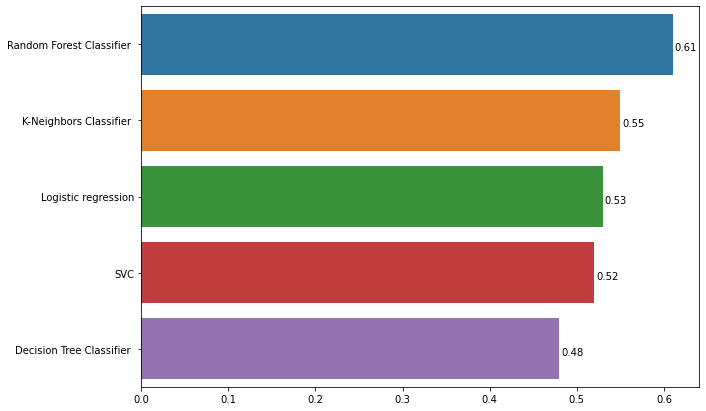

In [34]:
plt.figure(figsize=(10, 7))

keys = list(results.keys())
# get values in the same order as keys, and parse percentage values
vals = [results[k] for k in keys]
s = sns.barplot(x=vals, y=keys, orient = 'h')
for p in s.patches:
    width = p.get_width()
    plt.text(0.015+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center')

# 5. Оценка 

Частично оценка модели по метрикам уже проводилась на предыдущем этапе с целью выбрать наиболее подходящий классификатор. Приведем здесь accuracy модели в качестве некой опорной точки. 

In [112]:
y_pred = rfc.predict(x_test)
print(f'Accuracy score of {rfc.__class__.__name__} on test: {round(accuracy_score(y_pred, y_test), 3)}')

Accuracy score of RandomForestClassifier on test: 0.618


Этот результат еще может быть улучшен. Для этого требуется снова вернуться на этапы подготовки данных и моделирования для проверки новых гипотез. Однако для целей данной работы, думаю, что такой результат допустим.

# 6. Развертывание

На Kaggle по ссылке к исходному датасету отсутствует тестовая выборка, по данным которой можно было бы сделать сабмит, так что в данном случае упрощенным примером развертывания будет сама сдача этой работы как выполненного домашнего задания